# IMPORT

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense
from tensorflow.keras.utils import to_categorical


## PRAPROSES ( TOKENEZIR, PADDING, SPLIT DATA)

In [2]:
# Load the dataset
data_path = 'augmentasifix.xlsx'
data = pd.read_excel(data_path)

# praproses
texts = data['formal_text'].astype(str).values
tokenizer = Tokenizer(num_words=5000) # aktual 30k
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data_padded = pad_sequences(sequences, maxlen=50)

# asumsi labell
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust','anies','prabowo','ganjar']
labels = data[label_columns].values

# Split data
#X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    data_padded, labels, test_size=0.1, random_state=42, shuffle=True,)



In [3]:
text_lengths = [len(text.split()) for text in texts]
print(np.mean(text_lengths))

14.113533662356053


## CEK DISTRIBUSI LABEL

anger: 23091
anticipation: 4614
disgust: 25740
fear: 6567
joy: 35601
sadness: 5703
surprise: 8550
trust: 36531
anies: 24092
prabowo: 20568
ganjar: 7591


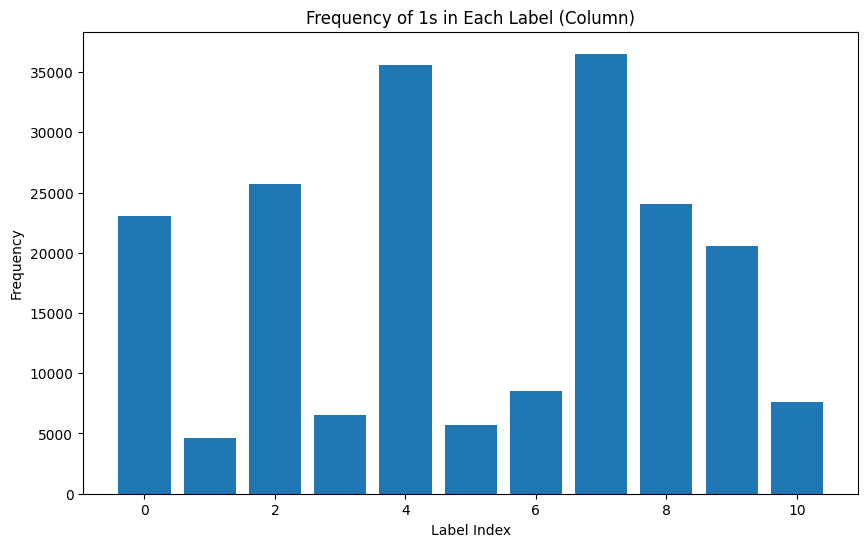

In [4]:
import matplotlib.pyplot as plt

# Count frequency of 1s in each column
label_frequencies = np.sum(labels, axis=0)
for label, label_freq in zip(label_columns, label_frequencies):
    print(f"{label}: {label_freq}")

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(label_frequencies)), label_frequencies)
plt.xlabel("Label Index")
plt.ylabel("Frequency")
plt.title("Frequency of 1s in Each Label (Column)")
plt.show()

## IMPLEMENTASI CLASS WEIGHT

Cara Kerja: class_weight menyesuaikan bobot kesalahan (loss) yang diterima selama pelatihan model berdasarkan frekuensi label. Bobot yang lebih tinggi diberikan kepada kelas yang lebih jarang, yang berarti bahwa kesalahan dalam memprediksi label minoritas akan memiliki dampak yang lebih besar pada pembelajaran model, seolah-olah ada lebih banyak contoh dari kelas tersebut.
Efek pada Data: Tidak ada perubahan fisik pada data; hanya fungsi loss yang dimodifikasi untuk mengkompensasi ketidakseimbangan.

In [5]:
class_weight = {}
for idx, label_freq in enumerate(label_frequencies):
    class_weight[idx] = (1 / label_freq) * (label_frequencies.sum() / 2)
    
class_weight

{0: 4.301416136156944,
 1: 21.52665799739922,
 2: 3.858741258741259,
 3: 15.1247144814984,
 4: 2.7899216314148476,
 5: 17.41609679116255,
 6: 11.616842105263158,
 7: 2.7188962798718896,
 8: 4.122696330732193,
 9: 4.829054842473746,
 10: 13.08444210248979}


## MODEL

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from keras import optimizers

model = Sequential()
model.add(Embedding(len(word_index) + 1, 64))
model.add(Dropout(0.1))
#model.add(Conv1D(16, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(Dense(len(label_columns), activation='sigmoid'))
model.add(Dropout(0.1))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', AUC(multi_label=True), Precision(), Recall()])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1946944   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirection  (None, None, 32)          10368     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 32)                

In [7]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=128,
    class_weight=class_weight,
    callbacks=early_stopping
)

# Menyimpan model
model.save('modelBi-LSTM90/10.h5')


Epoch 1/50


676/676 [==============================] - 46s 56ms/step - loss: 3.4805 - accuracy: 0.1565 - auc: 0.6591 - precision: 0.5792 - recall: 0.2075 - val_loss: 0.3061 - val_accuracy: 0.1535 - val_auc: 0.8182 - val_precision: 0.8659 - val_recall: 0.3921
Epoch 2/50
676/676 [==============================] - 37s 54ms/step - loss: 3.0094 - accuracy: 0.1789 - auc: 0.7668 - precision: 0.7946 - recall: 0.4243 - val_loss: 0.3111 - val_accuracy: 0.1726 - val_auc: 0.8440 - val_precision: 0.8357 - val_recall: 0.3784
Epoch 3/50
676/676 [==============================] - 36s 54ms/step - loss: 2.8863 - accuracy: 0.1990 - auc: 0.7883 - precision: 0.7825 - recall: 0.4891 - val_loss: 0.2696 - val_accuracy: 0.1925 - val_auc: 0.8632 - val_precision: 0.8512 - val_recall: 0.5001
Epoch 4/50
676/676 [==============================] - 36s 54ms/step - loss: 2.7787 - accuracy: 0.2076 - auc: 0.8048 - precision: 0.7829 - recall: 0.5255 - val_loss: 0.2585 - val_accuracy: 0.1737 - val_auc: 0.8757 - val_preci

C:\Users\Legion\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## EVALUASI MODEL

In [8]:
print(model.evaluate(X_test, y_test))

301/301 [==============================] - 3s 8ms/step - loss: 0.2058 - accuracy: 0.2302 - auc: 0.9220 - precision: 0.8426 - recall: 0.6989
[0.20578786730766296, 0.23019260168075562, 0.9220117926597595, 0.8426043391227722, 0.6988778710365295]


In [9]:
loss, accuracy, auc, precision, recall = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
print(f'Test AUC: {auc}, Test Precision:{precision}, Test Recall: {recall}')

301/301 [==============================] - 3s 8ms/step - loss: 0.2058 - accuracy: 0.2302 - auc: 0.9220 - precision: 0.8426 - recall: 0.6989
Test Loss: 0.20578786730766296, Test Accuracy: 0.23019260168075562
Test AUC: 0.9220117926597595, Test Precision:0.8426043391227722, Test Recall: 0.6988778710365295


### Confusion Matrix

301/301 [==============================] - 4s 8ms/step


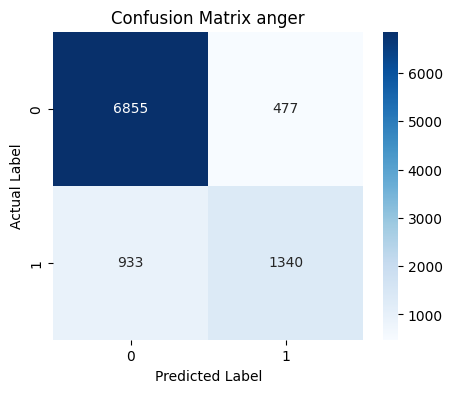

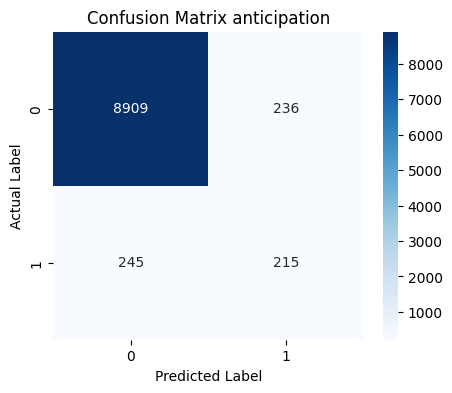

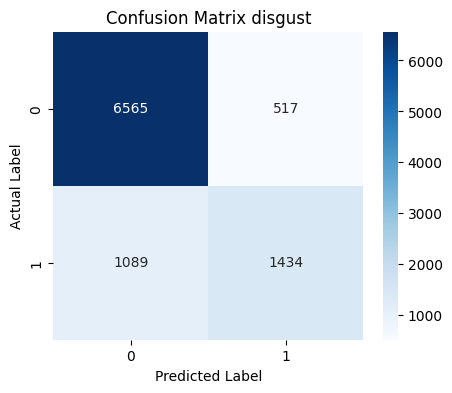

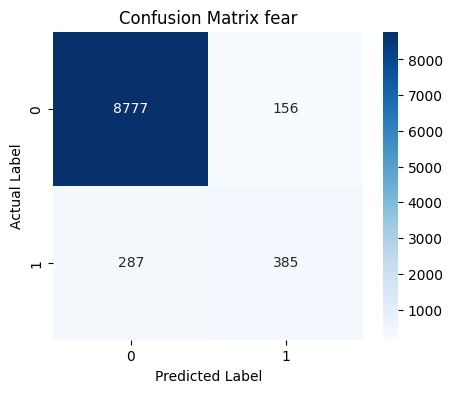

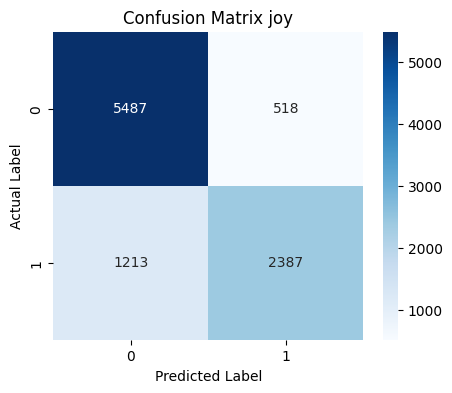

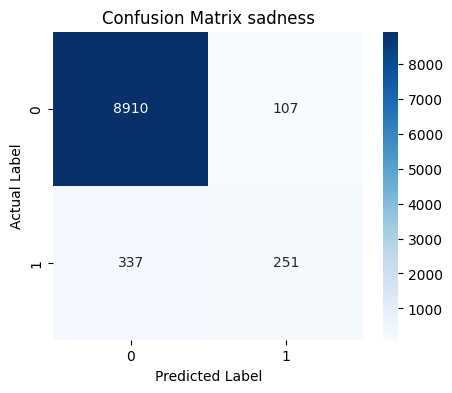

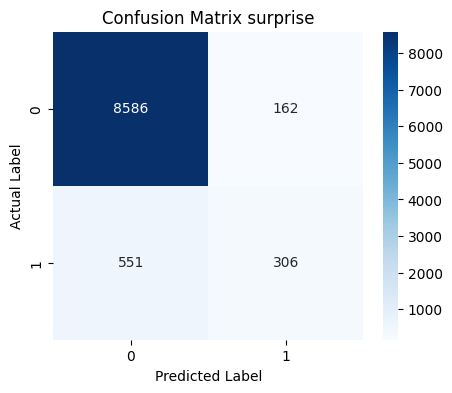

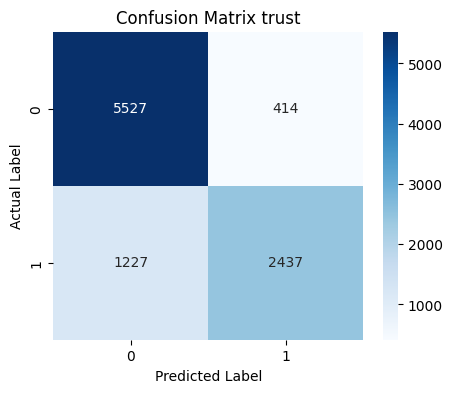

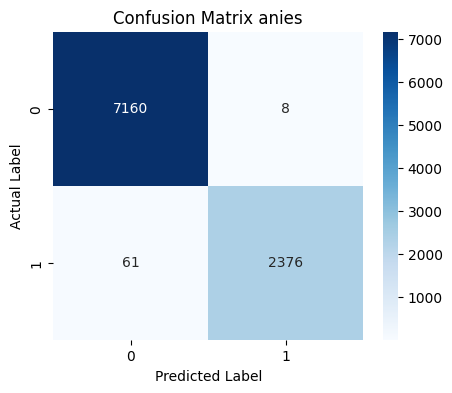

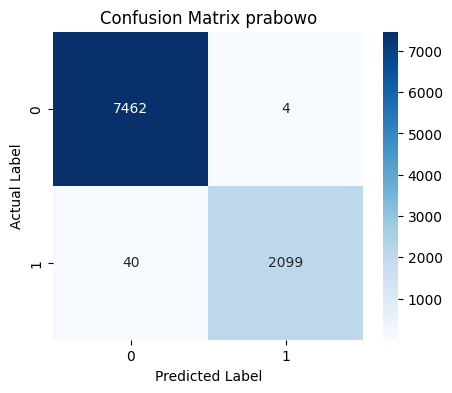

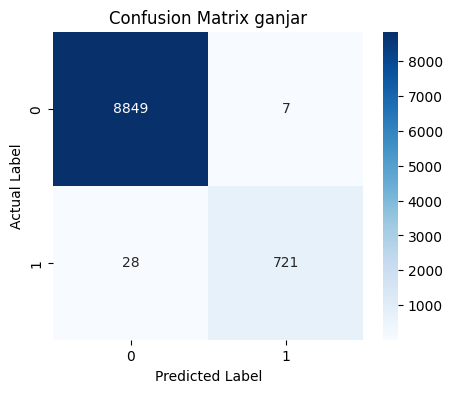

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Melakukan prediksi pada data validasi
y_pred = model.predict(X_test)


# Assuming y_pred_binary_adjusted has been computed based on an optimal threshold
for i, label in enumerate(label_columns):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i] > 0.5)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix {label}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Menghitung akurasi, presisi, dan recall per label
metrics = {}
for i, label in enumerate(label_columns):
    label_pred = y_pred[:, i] > 0.5  # Menggunakan threshold 0.5 untuk binerisasi
    accuracy = accuracy_score(y_test[:, i], label_pred)
    precision = precision_score(y_test[:, i], label_pred)
    recall = recall_score(y_test[:, i], label_pred)
    metrics[label] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

# Mencetak akurasi, presisi, dan recall per label
for label, metric in metrics.items():
    print(f'Accuracy for label {label}: {metric["accuracy"]}')
    print(f'Precision for label {label}: {metric["precision"]}')
    print(f'Recall for label {label}: {metric["recall"]}')
    print()


Accuracy for label anger: 0.8532014575741801
Precision for label anger: 0.7374793615850302
Recall for label anger: 0.5895292564892213

Accuracy for label anticipation: 0.9499219156689225
Precision for label anticipation: 0.47671840354767187
Recall for label anticipation: 0.4673913043478261

Accuracy for label disgust: 0.8327954190525768
Precision for label disgust: 0.735007688364941
Recall for label disgust: 0.5683709869203329

Accuracy for label fear: 0.953878188443519
Precision for label fear: 0.711645101663586
Recall for label fear: 0.5729166666666666

Accuracy for label joy: 0.8197813638729828
Precision for label joy: 0.8216867469879519
Recall for label joy: 0.6630555555555555

Accuracy for label sadness: 0.9537740760020822
Precision for label sadness: 0.7011173184357542
Recall for label sadness: 0.4268707482993197

Accuracy for label surprise: 0.9257678292555961
Precision for label surprise: 0.6538461538461539
Recall for label surprise: 0.3570595099183197

Accuracy for label trust

In [12]:
from sklearn.metrics import jaccard_score

# Menggabungkan semua prediksi dan label sebenarnya dalam satu dimensi
y_pred_flat = y_pred.ravel() > 0.5  # Menggunakan threshold 0.5 untuk binerisasi
y_test_flat = y_test.ravel()

# Menghitung skor Jaccard secara keseluruhan
jaccard_overall = jaccard_score(y_test_flat, y_pred_flat)

print(f'Overall Jaccard similarity: {jaccard_overall}')


Overall Jaccard similarity: 0.6181761786600496


## AUC DAN HAMMING LOSS


301/301 [==============================] - 2s 8ms/step


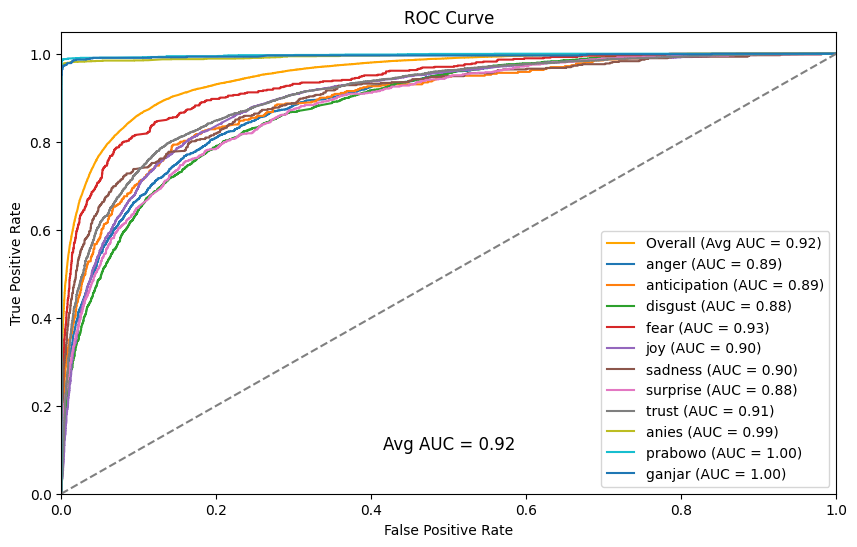

Test AUC: 0.92
Threshold: 0.10, Hamming Loss: 0.1397
Threshold: 0.20, Hamming Loss: 0.1024
Threshold: 0.30, Hamming Loss: 0.0877
Threshold: 0.40, Hamming Loss: 0.0821
Threshold: 0.50, Hamming Loss: 0.0816
Threshold: 0.60, Hamming Loss: 0.0843
Threshold: 0.70, Hamming Loss: 0.0915
Threshold: 0.80, Hamming Loss: 0.1060
Threshold: 0.90, Hamming Loss: 0.1305


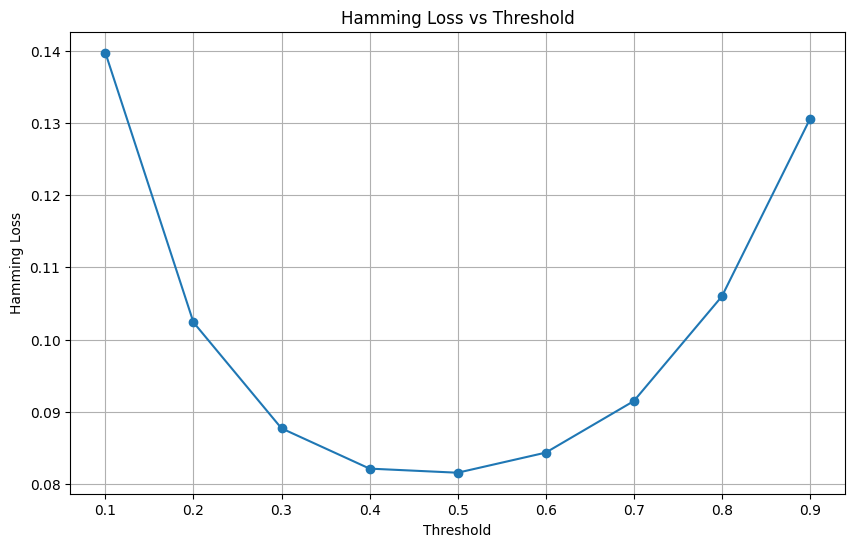

Test AUC: 0.92, Test Precision:0.99, Test Recall: 0.96


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer

# Prediksi probabilitas dari model
y_pred_prob = model.predict(X_test)

# Hitung rata-rata AUC dari semua kelas
auc_scores = []
for i in range(len(label_columns)):
    auc_score = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
    auc_scores.append(auc_score)

avg_auc = np.mean(auc_scores)

# Hitung kurva ROC secara keseluruhan
fpr_all, tpr_all, _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())

# Plot ROC curve untuk keseluruhan
plt.figure(figsize=(10, 6))
plt.plot(fpr_all, tpr_all, label=f'Overall (Avg AUC = {avg_auc:.2f})', color='orange')

# Plot kurva ROC untuk setiap kelas
for i in range(len(label_columns)):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'{label_columns[i]} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Tampilkan teks untuk nilai AUC keseluruhan
plt.text(0.5, 0.1, f'Avg AUC = {avg_auc:.2f}', fontsize=12, ha='center')

plt.show()

# Tampilkan hasil AUC keseluruhan
print(f'Test AUC: {avg_auc:.2f}')

# Tentukan threshold untuk konversi probabilitas menjadi label biner
thresholds = np.arange(0.1, 1.0, 0.1)

# Inisialisasi list untuk menyimpan nilai Hamming Loss untuk setiap threshold
hamming_losses = []

# Hitung Hamming Loss untuk setiap threshold
for threshold in thresholds:
    # Konversi probabilitas prediksi menjadi label biner berdasarkan threshold
    y_pred_binary = (y_pred_prob >= threshold).astype(int)
    y_pred_binary_adjusted = y_pred_binary[:, :y_test.shape[1]]
    
    # Hitung Hamming Loss
    hamming_loss_value = hamming_loss(y_test, y_pred_binary_adjusted)
    hamming_losses.append(hamming_loss_value)
 # Cetak nilai Hamming Loss untuk setiap threshold
    print(f'Threshold: {threshold:.2f}, Hamming Loss: {hamming_loss_value:.4f}')

# Plot grafik Hamming Loss
plt.figure(figsize=(10, 6))
plt.plot(thresholds, hamming_losses, marker='o', linestyle='-')
plt.title('Hamming Loss vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Hamming Loss')
plt.grid(True)
plt.show()

# Tampilkan hasil evaluasi keseluruhan
print(f'Test AUC: {avg_auc:.2f}, Test Precision:{precision:.2f}, Test Recall: {recall:.2f}')



## HASIL PREDIKSI

In [ ]:
predictions = model.predict(X_test)

threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)
predicted_df = pd.DataFrame(predicted_labels, columns=['Predicted_' + col for col in label_columns])

result_df = pd.concat([data, predicted_df], axis=1)
export_path = 'prediksi.xlsx'
result_df.to_excel(export_path, index=False)

print(f"prediksi {export_path}")

## Cek Dengan kalimat baru

In [ ]:
import numpy as np

# teks baru
new_text = "anies"

# tokenizer dan padding
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded = pad_sequences(new_sequence, maxlen=200)

# prediksi
new_prediction = model.predict(new_padded)
threshold = 0.5
new_predicted_labels = (new_prediction > threshold).astype(int)


emotion_labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust','anies','prabowo','ganjar']
predicted_emotions = [emotion_labels[i] for i, pred in enumerate(new_predicted_labels[0]) if pred == 1]

# Print hasil
print(f"prediksi: {', '.join(predicted_emotions)}")


## Distribusi Label Emosi Paslon

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predicted_labels to DataFrame
predicted_labels_df = pd.DataFrame(predicted_labels, columns=['anies', 'prabowo', 'ganjar', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'])

# Plot label distribution for each politician
politicians = ['anies', 'prabowo', 'ganjar']

# Set up the grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=len(politicians), figsize=(15, 6))

for i, politician in enumerate(politicians):
    # Filter data for the current politician
    politician_data = predicted_labels_df[predicted_labels_df[politician] == 1]
    # Drop politician columns to focus only on emotions
    politician_data = politician_data.drop(columns=politicians)
    
    # Calculate label distribution for emotions
    emotion_distribution = politician_data.sum()
    
    # Plot the distribution
    sns.barplot(x=emotion_distribution.index, y=emotion_distribution.values, palette='Blues', ax=axes[i])
    axes[i].set_title(f'Emotion Label Distribution for {politician.capitalize()}')
    axes[i].set_xlabel('Emotions')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 5 Kalimat yang mengiterpretasikan EMOSI tiap PASLON


In [ ]:
import pandas as pd

# Load the data
# Misalkan Anda memiliki file CSV yang berisi data
data_path = "augmentasifix.xlsx"
predicted_labels_df = pd.read_excel(data_path)

# Define the list of emotions
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

# Function to extract example sentences for each emotion for a given politician
def extract_example_sentences(data, politician):
    example_sentences = {}
    for emotion in emotions:
        # Filter data for the current politician and emotion
        politician_emotion_data = data[(data[politician] == 1) & (data[emotion] == 1)]
        # Sort the data by the probability of the emotion in descending order
        politician_emotion_data_sorted = politician_emotion_data.sort_values(by=emotion, ascending=False)
        # Take the top 3 example sentences for the current emotion
        example_sentences[emotion] = politician_emotion_data_sorted.head(3)['formal_text'].tolist()
    return example_sentences

# List of politicians
politicians = ['anies', 'prabowo', 'ganjar']

# Iterate through each politician
for politician in politicians:
    print(f"Politician: {politician.capitalize()}")
    # Filter data for the current politician
    politician_data = predicted_labels_df[predicted_labels_df[politician] == 1]
    example_sentences = extract_example_sentences(politician_data, politician)
    # Print example sentences for each emotion
    for emotion, sentences in example_sentences.items():
        if sentences:
            print(f"{emotion.capitalize()}:")
            for sentence in sentences:
                print(f"- {sentence}")
    print()





## SNA

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load data
data_path = 'Update_Data.xlsx'
data = pd.read_excel(data_path)

# Membuat graf
G = nx.Graph()

# Menambahkan nodes untuk tokoh politik dan emosi
politicians = ['anies', 'prabowo', 'ganjar']
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

# Menambahkan nodes dengan atribut
for politician in politicians:
    G.add_node(politician, color='blue', size=700, type='politician')

for emotion in emotions:
    G.add_node(emotion, color='red', size=500, type='emotion')

# Menambahkan edges berdasarkan jumlah komentar yang mengasosiasikan tokoh dengan emosi tertentu
for emotion in emotions:
    for politician in politicians:
        weight = data[data[politician] == 1][emotion].sum()
        if weight > 0:
            G.add_edge(politician, emotion, weight=weight)

# Mengatur warna dan ukuran node
node_colors = [G.nodes[node]['color'] for node in G]
node_sizes = [G.nodes[node]['size'] for node in G]

# Mengatur lebar garis berdasarkan bobot
edge_widths = [edgedata['weight'] / 300 for _, _, edgedata in G.edges(data=True)]

# Menggunakan layout yang lebih menarik
pos = nx.spring_layout(G, k=0.15, iterations=20)

# Menggambar graf dengan visualisasi yang lebih baik
plt.figure(figsize=(14, 12))
nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, width=edge_widths,
        with_labels=True, font_size=12, font_color='white', edge_color='#FF5733')
plt.title("Emotional Associations with Political Figures")
plt.show()
